In [18]:
import nolds
from scipy.stats import entropy
from antropy import higuchi_fd, perm_entropy

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utils import load_data

import warnings
from typing import Dict, TypedDict, Callable, Any

In [19]:
df = load_data("./data/ForbushDecrease/2023-04-23/all.txt")
df.index = df["datetime"]
df.drop(columns="datetime", inplace=True)
df

,ATHN,MXCO,NANM,CALM,ROME,AATB,BKSN,JUNG,JUNG1,LMKS,...,JBGO,NAIN,PWNK,THUL,MWSN,SOPB,SOPO,DOMB,DOMC,TERA
datetime,,,,,,,,,,,,,,,,,,,,,
2023-04-23 00:00:00,56.182,217.383,253.382,NaN,118.000,1301.6,130.170,150.136,349.538,415.346,...,NaN,198.49,213.80,116.42,215.482,135.37,276.92,4.660,17.456,109.176
2023-04-23 00:01:00,52.846,221.100,258.798,NaN,123.967,1282.8,127.505,154.071,349.006,418.165,...,256.21,203.56,204.96,119.65,223.857,134.08,275.25,4.790,17.739,112.275
2023-04-23 00:02:00,53.306,219.650,263.611,NaN,119.617,1294.4,124.252,153.263,348.047,424.944,...,257.14,198.66,209.83,115.51,221.355,136.69,277.01,4.493,18.394,111.132
2023-04-23 00:03:00,52.912,223.200,258.781,NaN,119.417,1317.4,122.385,156.517,353.549,423.495,...,NaN,200.03,206.39,118.91,212.872,136.84,284.17,5.273,16.882,108.487
2023-04-23 00:04:00,54.893,218.417,254.123,NaN,119.533,1298.5,126.092,155.687,341.097,420.367,...,NaN,202.88,198.21,120.45,220.680,135.59,279.40,4.976,17.678,110.898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-24 23:55:00,52.741,218.400,255.364,72.033,118.850,1281.3,125.709,153.080,346.768,421.473,...,NaN,194.73,205.69,112.67,213.265,130.70,269.62,4.557,16.254,110.312
2023-04-24 23:56:00,49.457,219.250,259.947,69.067,120.317,1272.8,124.285,153.852,354.916,415.708,...,249.79,194.40,198.99,114.05,213.048,131.37,270.49,4.468,18.175,110.203
2023-04-24 23:57:00,53.623,218.100,259.404,73.200,119.083,1256.3,125.522,149.907,340.224,415.544,...,249.31,197.86,200.50,111.94,219.132,132.31,270.29,4.671,18.176,105.603


In [20]:
# Taking just one station for simplicity
pwnk_station = df[["PWNK"]]
pwnk_station

,PWNK
datetime,
2023-04-23 00:00:00,213.80
2023-04-23 00:01:00,204.96
2023-04-23 00:02:00,209.83
2023-04-23 00:03:00,206.39
2023-04-23 00:04:00,198.21
...,...
2023-04-24 23:55:00,205.69
2023-04-24 23:56:00,198.99
2023-04-24 23:57:00,200.50


## Create Sliding Windows and calc metrics for each one

Sliding windows pandas documentation: [Here](https://pandas.pydata.org/docs/user_guide/window.html).  
Pandas `rolling` documentation: [Here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html#pandas.DataFrame.rolling).

Interesting metric to see: [Burstiness Parameter](https://arxiv.org/pdf/1604.01125)

In [21]:
class MetricDetails(TypedDict):
    func: Callable[..., np.float64 | np.ndarray]
    kwargs: Dict[str, Any]


# Unit terms
WINDOW_SIZE = 120  # 1 unit === 1 minute each window

# Datetime terms
# WINDOW_SIZE = "60min"


METRICS: Dict[str, MetricDetails] = {
    # Scipy metrics
    "entropy": {
        "func": lambda x, kwargs: entropy(x, **kwargs),
        "kwargs": {},
    },

    # AntroPy metrics
    "permutation_entropy": {
        "func": lambda x, kwargs: perm_entropy(x, **kwargs),
        "kwargs": {"normalize": False, "order": 3, "delay": 1},  # Default parameters
    },

    "higuchi": {
        "func": lambda x, kwargs: higuchi_fd(x, **kwargs),
        "kwargs": {"kmax": 10},
    },

    # Search for more metrics

    # Nolds metrics. Maybe, will be necessary to change each metric kwargs
    # e.g. order for dfa, emb_dim using elbow method, etc.
    "sampen": {
        "func": lambda x, kwargs: nolds.sampen(x, **kwargs),
        "kwargs": {},
    },
    "hurst": {
        "func": lambda x, kwargs: nolds.hurst_rs(x, **kwargs),
        "kwargs": {},
    },
    "dfa": {
        "func": lambda x, kwargs: nolds.dfa(x, **kwargs),
        "kwargs": {"order": 1, "overlap": True},
    },
    "corr_dim": {
        "func": lambda x, kwargs: nolds.corr_dim(x, **kwargs),
        "kwargs": {"emb_dim": 2},
    },

    # So much problems with `ValueError: Not enough data points`
    # "lyap_r": {
    #     "func": lambda x, kwargs: nolds.lyap_r(x, **kwargs),
    #     "data": [],
    #     "kwargs": {}
    # },
    
    # This returns a vector of `matrix_dim`. I'll skip it meanwhile
    # "lyap_e": {
    #     "func": lambda x, kwargs: nolds.lyap_e(x, **kwargs),
    #     # `emb_dim` - 1 must be divisible by `matrix_dim` - 1
    #     "kwargs": {"emb_dim": 10, "matrix_dim": 4},  # Default parameters
    # },

    "mfhurst_b": {
        "func": lambda x, kwargs: nolds.mfhurst_b(x, **kwargs),
        "kwargs": {},
    },
    
    # This returns a vector too. I'll skip it meanwhile
    # "mfhurst_dm": {
    #     "func": lambda x, kwargs: nolds.mfhurst_dm(x, **kwargs),
    #     "kwargs": {},
    # },
}

In [22]:
pwnk_station_rolling = pwnk_station.rolling(WINDOW_SIZE, center=True)
metric_data = {
    **{"datetime_i": [], "value_i": [], "window_shape": []},
    **{metric: [] for metric in METRICS},
}

In [23]:
with warnings.catch_warnings(record=True) as w:
    warnings.simplefilter("always")

    for i, window in enumerate(pwnk_station_rolling):
        if window.empty:
            continue

        data = window.PWNK.dropna().to_numpy()
        metric_data["datetime_i"].append(pwnk_station.index[i])
        metric_data["value_i"].append(pwnk_station.iloc[i, 0])
        metric_data["window_shape"].append(data.shape[0])

        for metric, details in METRICS.items():
            try:
                result = details["func"](data, kwargs=details["kwargs"])
            except Exception as e:
                print(
                    f"Error: {repr(e)} -- Index: {i} & {data.shape[0]} -- Metric: {metric}"
                )
                continue

            if metric == "mfhurst_b":
                result = result[0]
            metric_data[metric].append(result)

    # messages = set()

    # if w:
    #     print(f"Caught {len(w)} warnings:")
    #     for warning_item in w:
    #         message = str(warning_item.message)
    #         if message in messages:
    #             continue

    #         print(f"  Message: {message}")
    #         print(f"  Category: {warning_item.category.__name__}")
    #         print(f"  Lineno: {warning_item.lineno}")

    #         messages.add(message)
    # else:
    #     print("No warnings were caught.")


In [24]:
df_pwnk = pd.DataFrame(metric_data)
df_pwnk.index = pd.to_datetime(df_pwnk["datetime_i"])
df_pwnk.drop(columns=["datetime_i"], inplace=True)

df_pwnk.to_csv("./data/ForbushDecrease/2023-04-23/pwnk_metrics.csv", index=True)

df_pwnk

,value_i,window_shape,entropy,permutation_entropy,higuchi,sampen,hurst,dfa,corr_dim,mfhurst_b
datetime_i,,,,,,,,,,
2023-04-23 00:00:00,213.80,60,4.094161,2.523042,2.115191,1.475907,0.242215,0.599283,0.937854,-0.013553
2023-04-23 00:01:00,204.96,61,4.110690,2.530525,2.110084,1.475907,0.307824,0.615823,0.943008,-0.019816
2023-04-23 00:02:00,209.83,62,4.126952,2.541613,2.111448,1.475907,0.307824,0.610588,0.947886,-0.011638
2023-04-23 00:03:00,206.39,63,4.142955,2.546377,2.108354,1.531476,0.316307,0.612184,0.942652,-0.014828
2023-04-23 00:04:00,198.21,64,4.158706,2.548778,2.105694,1.558145,0.316307,0.617593,0.952366,-0.017592
...,...,...,...,...,...,...,...,...,...,...
2023-04-24 23:55:00,205.69,65,4.174259,2.539041,2.111449,1.609438,0.474254,0.659089,0.851802,-0.017109
2023-04-24 23:56:00,198.99,64,4.158757,2.533556,2.105726,1.686399,0.443753,0.616199,0.851928,-0.019785
2023-04-24 23:57:00,200.50,63,4.143012,2.537400,2.102667,1.648659,0.478977,0.758508,0.827929,-0.012278


## Plot everything

In [25]:
df_pwnk = pd.read_csv("./data/ForbushDecrease/2023-04-23/pwnk_metrics.csv")
df_pwnk["datetime_i"] = pd.to_datetime(df_pwnk["datetime_i"])

# Just in case I want to set the datetime as index again
# df_pwnk.index = df_pwnk["datetime_i"]
# df_pwnk.drop(columns=["datetime_i"], inplace=True)

df_pwnk

,datetime_i,value_i,window_shape,entropy,permutation_entropy,higuchi,sampen,hurst,dfa,corr_dim,mfhurst_b
0,2023-04-23 00:00:00,213.80,60,4.094161,2.523042,2.115191,1.475907,0.242215,0.599283,0.937854,-0.013553
1,2023-04-23 00:01:00,204.96,61,4.110690,2.530525,2.110084,1.475907,0.307824,0.615823,0.943008,-0.019816
2,2023-04-23 00:02:00,209.83,62,4.126952,2.541613,2.111448,1.475907,0.307824,0.610588,0.947886,-0.011638
3,2023-04-23 00:03:00,206.39,63,4.142955,2.546377,2.108354,1.531476,0.316307,0.612184,0.942652,-0.014828
4,2023-04-23 00:04:00,198.21,64,4.158706,2.548778,2.105694,1.558145,0.316307,0.617593,0.952366,-0.017592
...,...,...,...,...,...,...,...,...,...,...,...
2875,2023-04-24 23:55:00,205.69,65,4.174259,2.539041,2.111449,1.609438,0.474254,0.659089,0.851802,-0.017109
2876,2023-04-24 23:56:00,198.99,64,4.158757,2.533556,2.105726,1.686399,0.443753,0.616199,0.851928,-0.019785
2877,2023-04-24 23:57:00,200.50,63,4.143012,2.537400,2.102667,1.648659,0.478977,0.758508,0.827929,-0.012278
2878,2023-04-24 23:58:00,200.93,62,4.127012,2.529473,2.107267,1.568616,0.484395,0.554087,0.839988,-0.005682


In [26]:
metrics_columns = list(filter(lambda x: x in METRICS.keys(), df_pwnk.columns))
metrics_columns

['entropy',
 'permutation_entropy',
 'higuchi',
 'sampen',
 'hurst',
 'dfa',
 'corr_dim',
 'mfhurst_b']

In [27]:
data = {"datetime": [], "metric": [], "value": [], "window_shape": []}
for _, row in df_pwnk.iterrows():
    for metric in metrics_columns:
        data["datetime"].append(row["datetime_i"])
        data["metric"].append(metric)
        data["value"].append(row[metric])
        data["window_shape"].append(row["window_shape"])

df_plot = pd.DataFrame(data)
df_plot

,datetime,metric,value,window_shape
0,2023-04-23 00:00:00,entropy,4.094161,60
1,2023-04-23 00:00:00,permutation_entropy,2.523042,60
2,2023-04-23 00:00:00,higuchi,2.115191,60
3,2023-04-23 00:00:00,sampen,1.475907,60
4,2023-04-23 00:00:00,hurst,0.242215,60
...,...,...,...,...
23035,2023-04-24 23:59:00,sampen,1.749200,61
23036,2023-04-24 23:59:00,hurst,0.620747,61
23037,2023-04-24 23:59:00,dfa,0.674329,61
23038,2023-04-24 23:59:00,corr_dim,0.831727,61


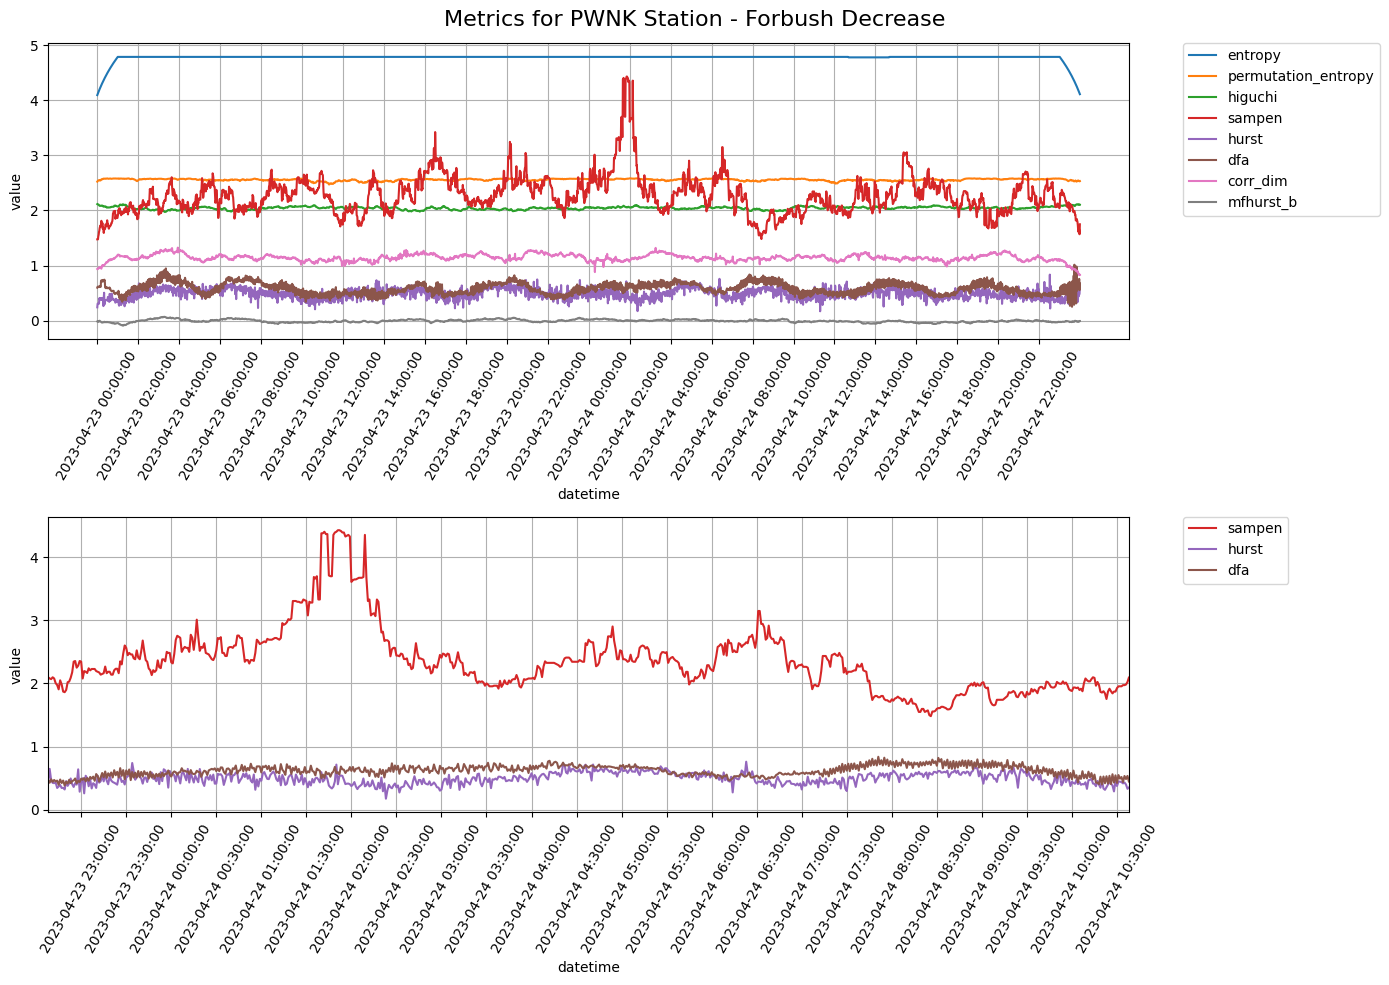

In [ ]:
def plot_metrics(
    df: pd.DataFrame,
    ax: plt.Axes,
    metrics: list[str] = ["*"],
    freq_date_range: str = "",
    colors: dict[str, str] = None,
) -> None:
    if "*" not in metrics:
        try:
            plot_df = df[df["metric"].isin(metrics)]
        except KeyError:
            plot_df = df.copy()
    else:  # If all metrics are requested or it's an empty list
        plot_df = df.copy()

    sns.lineplot(
        data=plot_df,
        x="datetime",
        y="value",
        hue="metric",
        ax=ax,
        palette=colors,
    )

    if freq_date_range:
        date_range = pd.date_range(
            start=plot_df["datetime"].min(),
            end=plot_df["datetime"].max(),
            freq=freq_date_range,
        ).to_list()

        ax.set_xticks(
            ticks=date_range,
            labels=list(map(lambda x: x.strftime("%Y-%m-%d %H:%M:%S"), date_range)),
            rotation=60,
        )

    ax.grid()
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)


fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plotting all metrics for the PWNK station of all time serie
plot_metrics(df_plot, axes[0], freq_date_range="2h")

colors = {}
for line in axes[0].get_lines():
    label = line.get_label()
    color = line.get_color()
    if label and not label.startswith('_'):  # Skip unnamed lines
        colors[label] = color

# Limiting the x-axis to a specific date range where the Forbush Decrease is more evident
plot_metrics(
    df_plot,
    axes[1],
    freq_date_range="30min",
    colors=colors,
    metrics=["sampen", "dfa", "hurst"],  # # Metrics important for me
)
axes[1].set_xlim(
    pd.to_datetime("2023-04-23 22:38:00"),
    pd.to_datetime("2023-04-24 10:38:00"),
)

fig.suptitle("Metrics for PWNK Station - Forbush Decrease", fontsize=16)

fig.tight_layout()
plt.show()